
## Tree Bagging vs Random Forest: Does tree decorrelation actually improve prediction accuracy?

##### Fuqiao Bai
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary
The objective of this work is to compare the perform of Tree bagging and Random forest models and investigate whether tree decorrelation  actually improve the prediction accuracy. Initially, I conducted a comprehensive data analysis on the loaded dataset, examining the data distributions and statics, eliminating outliers and identifying predictors features taht contribute insignificantly to the response feature. Following the feature engineering, I splitted the dataset into 70% training data and 30% testing data. Subsequently, I trained both tree bagging and random forest models to predict friction factor. Hyperparameter tuning by gridsearch is performed to compare the two model's performance aiming to discern if tree decorrelation, a characteristic of Random Forest through introducing randomness during the construction of individual trees, truly diminishes correlations and enhances prediction accuracy. To conclude, the tuned Random forest model exhibte superior performance compared to the tuned Tree bagging model, which means the the tree decorrelation by introducing randomness during the construction of individual trees did improve the accuracy. However, the performance between the Random forest and Tree bagging is case-dependent. I would recommend to evaluate both methods with proper validation and select the one that suits the data and problem domain better. In addition, hyperparameter tunning also plays a crucial role in optiminzing the performance of these two ensemble tree methods.

### Import Packages

In [28]:
import pandas as pd                                                 # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                                  # arrays and matrix math
import matplotlib.pyplot as plt                                     # plotting
from sklearn.tree import DecisionTreeRegressor                      # imposrt Decision Tree from Scikit-learn
from sklearn.ensemble import BaggingRegressor                       # imposrt Tree bagging from Scikit-learn
from sklearn.ensemble import RandomForestRegressor                  # imposrt Random Forest from Scikit-learn
from sklearn.model_selection import train_test_split                # Split the dataset
from sklearn.preprocessing import StandardScaler                    # Standardizing features
from sklearn.metrics import mean_squared_error                      # Calculate MSE
from sklearn.model_selection import GridSearchCV                    # Hyperparameter tuning
import seaborn as sns                                               # for matrix scatter plots
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)   # control of axes ticks

### Set the figure and font size

In [29]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams["font.size"] = 9
plt.rcParams['font.family'] = 'Arial'

### Functions

The following functions will be used in the workflow.

In [30]:
# function from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_DecisionTree.ipynb 
def plot_CDF(data,color,alpha=1.0,lw=1,ls='solid',label='none'): # plot the CDF for training data and tesing data,  
    cumprob = (np.linspace(1,len(data),len(data)))/(len(data)+1)
    plt.scatter(np.sort(data),cumprob,c=color,alpha=alpha,edgecolor='black',lw=lw,ls=ls,label=label,zorder=10)
    plt.plot(np.sort(data),cumprob,c=color,alpha=alpha,lw=lw,ls=ls,zorder=8)

def add_grid(): # set the grid for the CDF plots, function from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_DecisionTree.ipynb 
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

def hyperparameter_tuning(X_train, X_test, y_train, y_test, method,param_grid): # fucntion to do the hyperparameter tunning for each method
    # Choose the model and intial the model
    if method == 'RandomForest':
        model = RandomForestRegressor(random_state=73303, oob_score=True)
    elif method == 'TreeBagging':
        base_estimator = DecisionTreeRegressor(random_state=73303)
        model = BaggingRegressor(base_estimator=base_estimator, random_state=73303)
    else:
        raise ValueError("Invalid method. Choose between 'RandomForest' and 'TreeBagging'.")    
    # Use Grid Search for hyperparameter tunning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    # Find and output the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best Parameters for {method}: {best_params}") 
    # Re-train the model with tuned hyperparemeters
    best_model = model.set_params(**best_params)
    best_model.fit(X_train, y_train)
    # Applied model for prediction with the testing data and tuned model
    y_pred = best_model.predict(X_test)
    # Evaluate the performance of the final model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Tuned Mean Squared Error for {method}: {mse}")   
    return mse,y_pred

### Load Data

The following workflow applies the .csv file 'Project_Multiphaseflow data.csv', an experimental dataset from calculated with Hilde Andersen and calculated by Fuqiao Bai. The dataset is publically available [here](https://github.com/baialan/PGE-383-Machine-Learning--Final-project/blob/main/Final%20project/Project_Multiphaseflow%20data.csv)  

We will work with the following features:

* **Pressure** - The system presure of the pipeline, MPa
* **Temprature** - The system presure of the pipeline, &deg;C
* **Diameter** - the pipe inner diameter, mm
* **Ug** - Superfacial velocity of gas phase, m/s
* **Ul** - Superfacial velocity of liquid phase, m/s
* **H** - Liquid holdup, dimensionless
* **dp/dx** - frictional pressure drop, Pa/m
* **Density_mix** - the mixture density of gas and liquid phase, $kg/m^3$
* **Viscosity_mix** - the mixture density of gas and liquid phase, cp
* **friction factor** - friction correlation between the fluid and pipe wall


In [31]:
my_data  = pd.read_csv(r'https://raw.githubusercontent.com/baialan/PGE-383-Machine-Learning--Final-project/main/Final%20project/Project_Multiphaseflow%20data.csv')
# my_data = pd.read_csv("Project_Multiphaseflow data.csv") # load data
my_data.head(13)

,Pressure,Temprature,Diameter,Ug,Ul,H,dp/dx,Density_mix,Viscosity_mix,friction factor
0,4.5,10,44,3.87,0.05,0.01,353.0,142.330225,0.000017,0.011366
1,4.5,10,44,1.88,0.05,0.05,100.0,171.378254,0.000019,0.012094
2,4.5,10,44,0.51,0.05,0.18,17.0,265.784348,0.000028,0.014614
3,4.5,10,44,3.93,0.10,0.00,382.0,135.068217,0.000016,0.011355
4,4.5,10,44,2.06,0.10,0.05,126.0,171.378254,0.000019,0.011981
5,4.5,10,44,0.53,0.10,0.27,24.0,331.142413,0.000034,0.014628
6,4.5,10,44,4.98,0.50,0.08,940.0,193.164275,0.000021,0.011191
7,4.5,10,44,3.94,0.50,0.09,692.0,200.426283,0.000022,0.011357
8,4.5,10,44,0.52,0.50,0.52,92.0,512.692595,0.000051,0.014037
9,4.5,10,44,1.38,0.78,0.49,280.0,490.906573,0.000049,0.012609


Preview and sumarize the dataset:

In [32]:
my_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pressure,108.0,3.651296,0.730235,2.880000,2.880000,3.500000,4.500000,4.500000
Temprature,108.0,1.194444,7.644506,-7.000000,-7.000000,0.000000,10.000000,10.000000
Diameter,108.0,44.000000,0.000000,44.000000,44.000000,44.000000,44.000000,44.000000
Ug,108.0,2.489815,1.545192,0.220000,1.157500,2.100000,3.680000,5.360000
Ul,108.0,0.214352,0.211705,0.030000,0.050000,0.100000,0.500000,0.780000
H,108.0,0.166574,0.161796,0.000000,0.050000,0.100000,0.270000,0.700000
dp/dx,108.0,262.570370,229.431093,-19.000000,76.000000,224.500000,408.750000,940.000000
Density_mix,108.0,239.842912,130.857348,78.196302,147.847567,193.775168,320.467387,643.408725
Viscosity_mix,108.0,0.000029,0.000013,0.000014,0.000019,0.000023,0.000036,0.000071
friction factor,108.0,0.012640,0.001547,0.011191,0.011508,0.012077,0.013188,0.017946


From the above table, we found dp/dx has nagtive values. 
Therefore,  we reomve the rows where dp/dx column contains negative values and check the summarize the dataset again

In [33]:
my_data = my_data[my_data['dp/dx'] >= 0]
# check the data distribution now
my_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pressure,100.0,3.648200,0.723315,2.880000,2.880000,3.500000,4.500000,4.500000
Temprature,100.0,1.170000,7.570617,-7.000000,-7.000000,0.000000,10.000000,10.000000
Diameter,100.0,44.000000,0.000000,44.000000,44.000000,44.000000,44.000000,44.000000
Ug,100.0,2.651300,1.489715,0.440000,1.655000,2.515000,3.832500,5.360000
Ul,100.0,0.221900,0.214314,0.030000,0.050000,0.100000,0.500000,0.780000
H,100.0,0.168600,0.164575,0.000000,0.040000,0.100000,0.272500,0.700000
dp/dx,100.0,284.490000,224.361428,8.000000,97.500000,234.000000,424.500000,940.000000
Density_mix,100.0,241.104763,132.923537,78.196302,146.468232,195.661042,328.137152,643.408725
Viscosity_mix,100.0,0.000029,0.000013,0.000014,0.000018,0.000023,0.000037,0.000071
friction factor,100.0,0.012410,0.001263,0.011191,0.011466,0.011961,0.012702,0.016674


From the data preview, we can physically drop the pressure, temprature data that do not contribute to the friction factor.

In addition, the feature-diameter can be dropped since the values of it are all same which will not contribute much to our prediction result.

Then we extract the features to build a new dataset for continue studying.

In [34]:
# Extracting columns 3, 4, 5, 6, 8, 9, 10 from my_data, to drop the features does not contribute to our predictors
new_data = my_data.iloc[:, [3, 4, 5, 7, 8, 9]]
# Display the new DataFrame
new_data.head(13)

,Ug,Ul,H,Density_mix,Viscosity_mix,friction factor
0,3.87,0.05,0.01,142.330225,0.000017,0.011366
1,1.88,0.05,0.05,171.378254,0.000019,0.012094
2,0.51,0.05,0.18,265.784348,0.000028,0.014614
3,3.93,0.10,0.00,135.068217,0.000016,0.011355
4,2.06,0.10,0.05,171.378254,0.000019,0.011981
5,0.53,0.10,0.27,331.142413,0.000034,0.014628
6,4.98,0.50,0.08,193.164275,0.000021,0.011191
7,3.94,0.50,0.09,200.426283,0.000022,0.011357
8,0.52,0.50,0.52,512.692595,0.000051,0.014037
9,1.38,0.78,0.49,490.906573,0.000049,0.012609


### Feature engineering before Machine Learning

Plot histograms plots for each features to visualize their distributions.

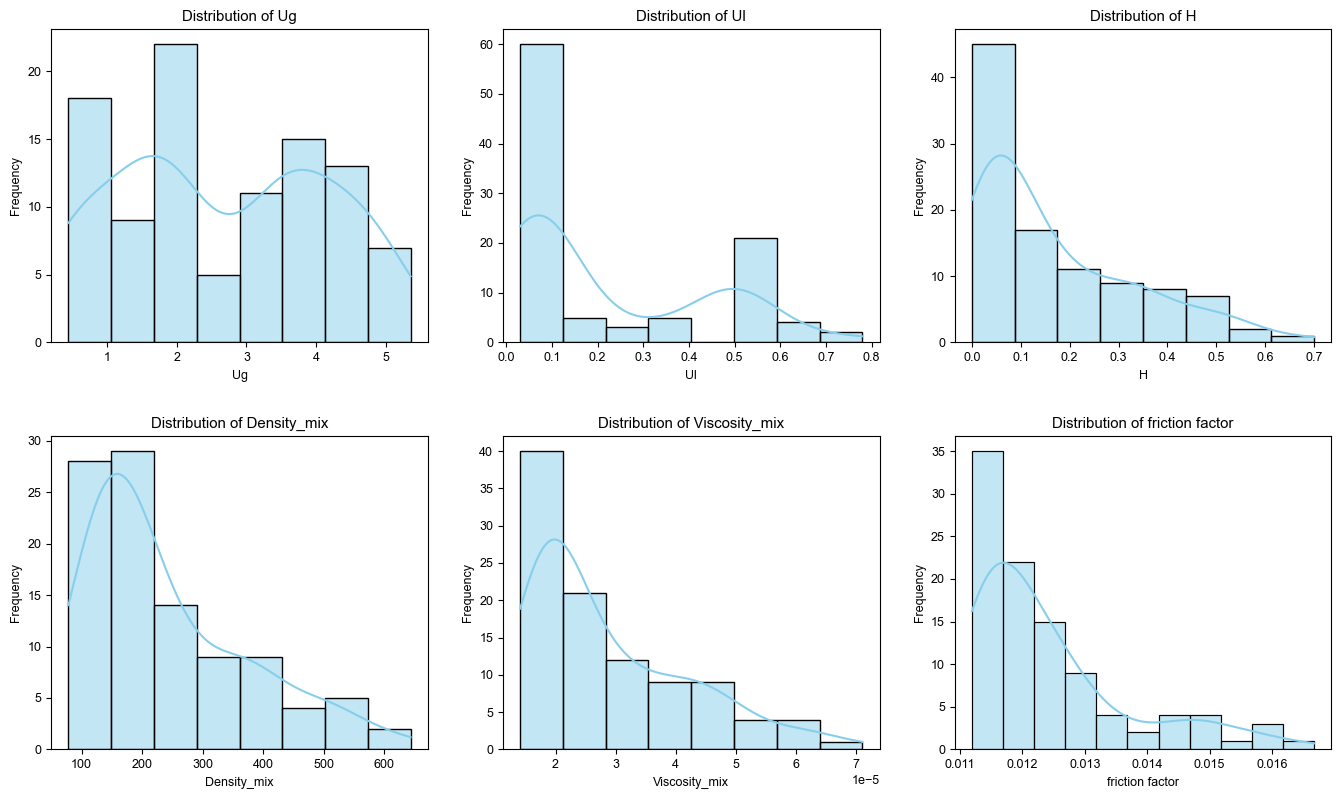

In [35]:
fig, axes = plt.subplots(2, 3) 
for i, column in enumerate(new_data.columns):
    row = i // 3  
    col = i % 3   
    sns.histplot(new_data[column], kde=True, ax=axes[row, col],color = 'skyblue')  
    axes[row, col].set_title(f'Distribution of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')
plt.tight_layout()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.3)
plt.show()

Contruct a correlation matrix to quanfify the relationships between features and identify any strong correlations. 

Visulize the correlation matrix using a heatmap plot

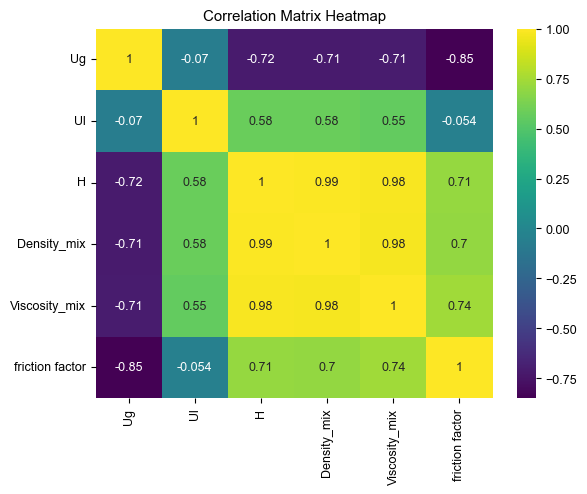

In [36]:
correlation_matrix = new_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix Heatmap')
plt.show()

The correlation matrix heatmap looks good and it a mix of correlation magnitudes. 

Due to the limited linear relationship from correlation matrix plot,

We use use matrix scatter plot to view more comprehensive relationships

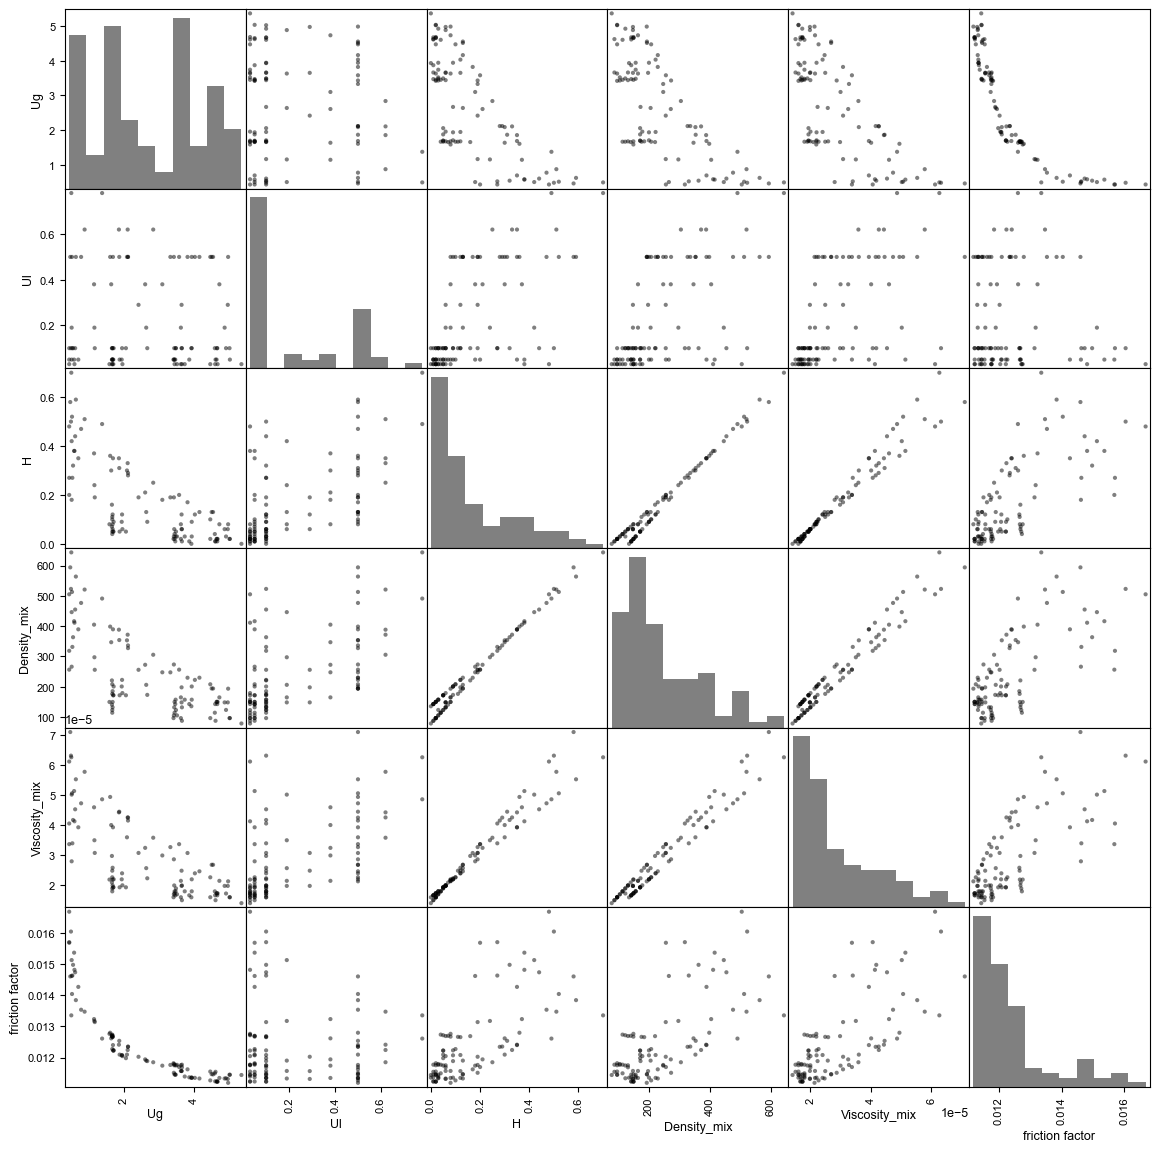

In [37]:
pd_plot.scatter_matrix(new_data, alpha = 0.5,                # pandas matrix scatter plot
    figsize=(14, 14),color = 'black', hist_kwds={'color':['gray']})
plt.show()

The matrix scatter plots exibit linear and non-linear relationship between features

### Split training and testing data

Standardize the predictor features since the features all have different magnitudes for different units

In [38]:
# Assuming new_data is your DataFrame with the specified columns
# Extract predictors (X) and response variable (y)
X = new_data.iloc[:, :5].values
y = new_data.iloc[:, -1].values
# Standardize the predictors (X)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.3, random_state=73303)

Check the Training and Testing Split data by plotting the CDF of training and testing data for each features
* ensure good testing coverage and avoid model extrapolation

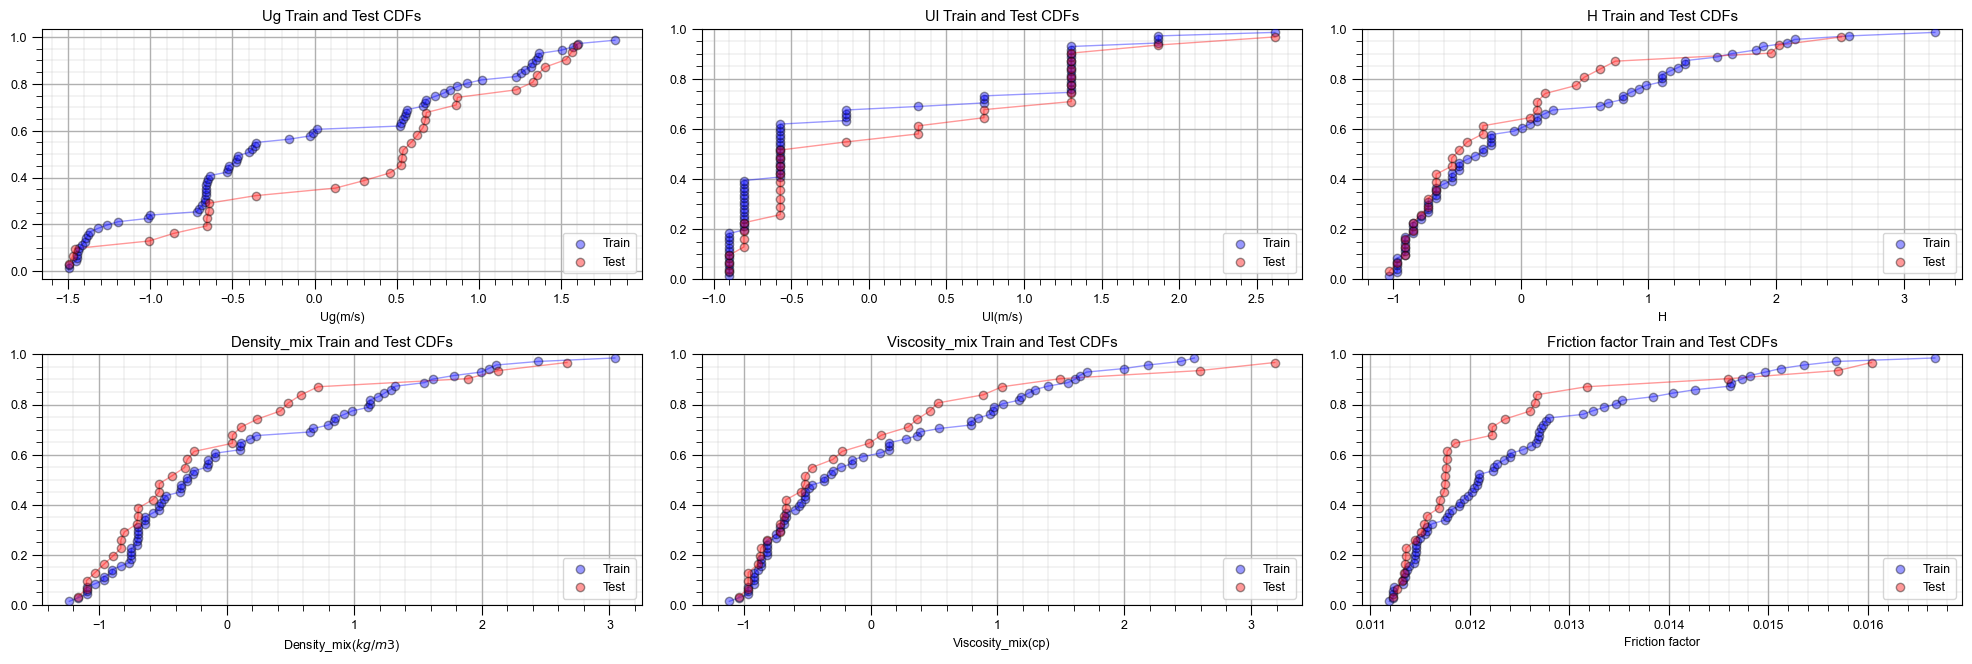

In [39]:
nbin = 20
plt.subplot(231)
plot_CDF(X_train[:, 0],'blue',alpha=0.4,lw=1,ls='solid',label='Train')
plot_CDF(X_test[:, 0],'red',alpha=0.4,lw=1,ls='solid',label='Test')
plt.xlabel('Ug(m/s)');  add_grid(); plt.legend(loc='lower right')
plt.title("Ug" + ' Train and Test CDFs')
plt.subplot(232)
plot_CDF(X_train[:, 1],'blue',alpha=0.4,lw=1,ls='solid',label='Train')
plot_CDF(X_test[:, 1],'red',alpha=0.4,lw=1,ls='solid',label='Test')
plt.xlabel('Ul(m/s)');  plt.ylim([0,1]); add_grid(); plt.legend(loc='lower right')
plt.title("Ul" + ' Train and Test CDFs')
plt.subplot(233)
plot_CDF(X_train[:, 2],'blue',alpha=0.4,lw=1,ls='solid',label='Train')
plot_CDF(X_test[:, 2],'red',alpha=0.4,lw=1,ls='solid',label='Test')
plt.xlabel('H');  plt.ylim([0,1]); add_grid(); plt.legend(loc='lower right')
plt.title("H" + ' Train and Test CDFs')
plt.subplot(234)
plot_CDF(X_train[:, 3],'blue',alpha=0.4,lw=1,ls='solid',label='Train')
plot_CDF(X_test[:, 3],'red',alpha=0.4,lw=1,ls='solid',label='Test')
plt.xlabel('Density_mix($kg/m3$)');  plt.ylim([0,1]); add_grid(); plt.legend(loc='lower right')
plt.title("Density_mix" + ' Train and Test CDFs')
plt.subplot(235)
plot_CDF(X_train[:, 4],'blue',alpha=0.4,lw=1,ls='solid',label='Train')
plot_CDF(X_test[:, 4],'red',alpha=0.4,lw=1,ls='solid',label='Test')
plt.xlabel('Viscosity_mix(cp)');  plt.ylim([0,1]); add_grid(); plt.legend(loc='lower right')
plt.title("Viscosity_mix" + ' Train and Test CDFs')
plt.subplot(236)
plot_CDF(y_train,'blue',alpha=0.4,lw=1,ls='solid',label='Train')
plot_CDF(y_test,'red',alpha=0.4,lw=1,ls='solid',label='Test')
plt.xlabel('Friction factor');  plt.ylim([0,1]); add_grid(); plt.legend(loc='lower right')
plt.title("Friction factor" + ' Train and Test CDFs')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.1, hspace=0.3)
plt.show()

It exhbits good coverage of the tesing data to allow to continue prediction with essemble tree methods.

### Tree bagging model
Tree Bagging is an ensemble trees method that combines multiple decision trees to create a more robust and accurate model. 
* Each tree inm the ensemble is constructed on the boostrap sampling of the original dataset,where the sample may include a few duplicate date due to the random sampling wiht replacement
* Averaging the predcitions from all trees for regression problems. Predictions from each tree are combined and averaged to generate the final prediction

Build the Tree bagging model and preview one result of the model

In [40]:
# Initialize the Decision Tree Regressor (base estimator for Bagging)
tree_reg = DecisionTreeRegressor(random_state=73303)
# Initialize the Bagging Regressor with DecisionTreeRegressor as the base estimator
bagging_model = BaggingRegressor(base_estimator=tree_reg, n_estimators=10, random_state=73303)
# Train the model on the training data
bagging_model.fit(X_train, y_train)
# Make predictions on the test data
y_pred_treebagging = bagging_model.predict(X_test)
# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred_treebagging)
print(f"Mean Squared Error for Tree bagging: {mse}")

Mean Squared Error for Tree bagging: 1.1041968179889986e-07


### Random forest model

Random Forest is also an ensemble learning method that constructs multiple decision trees, and each tree is trained on a random subset(Tree decorrelation) of the original training samples with replacement. This randomness leads to slightly different trees that are all somewhat independent of each other and it controls overfit. 
* Tree decorrelation(Feature randomness): Random Forest involves randomness in feature selection during each tree's growth but Tree bagging does not include this part

Build the Random model and preview one result of the model

In [41]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=5, random_state=73303,max_features=1,max_depth=10, oob_score = True)
# Train the model on the training data
rf_model.fit(X_train, y_train)
# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)
# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error for random forest: {mse}")

Mean Squared Error for random forest: 1.8835591042505364e-07


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


View the feature importance for the Random forest method:

1. feature 0 (0.477994)
2. feature 2 (0.273674)
3. feature 4 (0.149678)
4. feature 1 (0.070574)
5. feature 3 (0.028080)


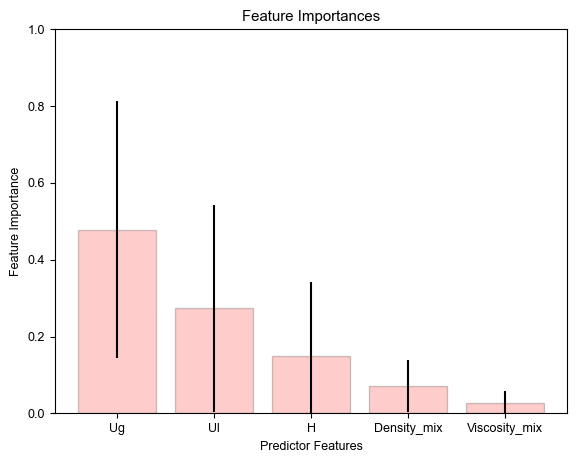

In [42]:
importances = rf_model.feature_importances_                                       # expected (global) importance over the forest fore each predictor feature
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],axis=0) # retrieve importance by tree
indices = np.argsort(importances)[::-1]
features = ['Ug','Ul','H','Density_mix','Viscosity_mix']                          # names or predictor features
for f in range(len(features)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
plt.subplot(111)
plt.title("Feature Importances")
plt.bar(features, importances[indices],color="red", alpha = 0.2, edgecolor = 'black', yerr=std[indices], align="center")
plt.ylim(0,1), plt.xlabel('Predictor Features'); plt.ylabel('Feature Importance')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

Visualize the actual value vs the predicted value to investigate the accuracy of first examination of both models

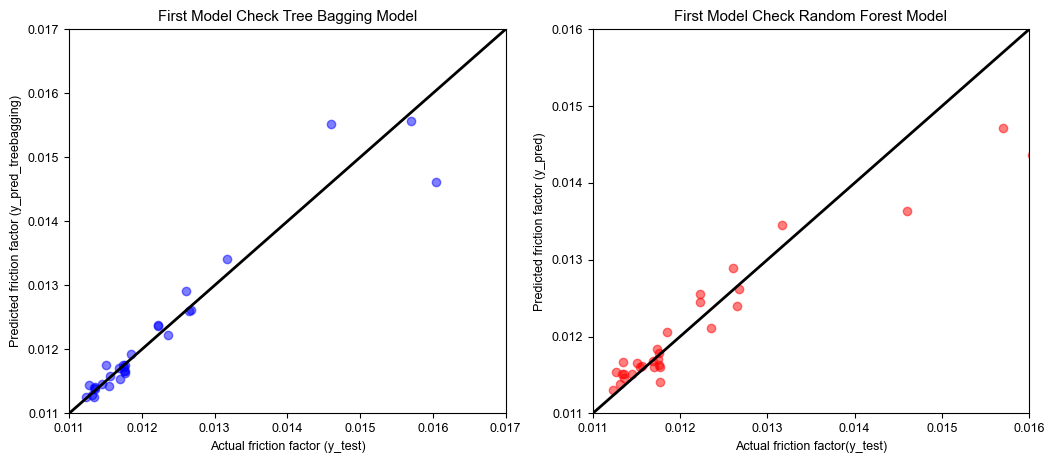

In [43]:
plt.subplot(121)
plt.scatter(y_test, y_pred_treebagging, alpha=0.5, color='blue')
plt.plot([0.011, 0.017], [0.011, 0.017], linestyle='-', color='black', linewidth=2)  # 45-degree line
plt.ylim(0.011,0.017)
plt.xlim(0.011,0.017)
plt.title('First Model Check Tree Bagging Model')
plt.xlabel('Actual friction factor (y_test)')
plt.ylabel('Predicted friction factor (y_pred_treebagging)')

plt.subplot(122)
plt.scatter(y_test, y_pred_rf, alpha=0.5,color = 'red')
plt.plot([0.011, 0.017], [0.011, 0.017], linestyle='-', color='black', linewidth=2)  # 45-degree line
plt.ylim(0.011,0.016)
plt.xlim(0.011,0.016)
plt.title('First Model Check Random Forest Model')
plt.xlabel('Actual friction factor(y_test)')
plt.ylabel('Predicted friction factor (y_pred)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

### Hyperparameter tuning

Use the Gridserch method for the hyperparameter tuning for each model.

Grid Search is a hyperparameter optimization method used to search for the best combination of hyperparameters for a machine learning model. It works by exhaustively evaluating a specified subset of hyperparameter combinations and selecting the combination that yields the best performance for the specific evaluation.

Hyperparameters for tree bagging model:
* n_estimators: number of trees
Hyperparameters for randome forest model:
* n_estimators: number of trees
* max_depth: the depth of each tree in the ensemble
* max_features: the maximum number of features to consider when deciding the best split at each node in a decision tree


##### Use the hyperparameter tuning function defined before to find the best hyperparameters combinations

In [44]:
param_grid_treebag = {
    'n_estimators': [5, 10, 20, 30,50],
}
param_grid_RF = {
    'n_estimators': [5, 10, 20, 30],
    'max_depth': [5, 10, 15, 20, None],
    'max_features': ['auto', 'sqrt','log2',1,2,3,4,5]  # "auto means sqrt(number of features), log2 is the log2(number of features)
}
msebag, y_predbag = hyperparameter_tuning(X_train, X_test, y_train, y_test, 'TreeBagging',param_grid_treebag)
mserf, y_predrf = hyperparameter_tuning(X_train, X_test, y_train, y_test, 'RandomForest',param_grid_RF)

Best Parameters for TreeBagging: {'n_estimators': 30}
Tuned Mean Squared Error for TreeBagging: 9.901220236337272e-08
Best Parameters for RandomForest: {'max_depth': 10, 'max_features': 4, 'n_estimators': 10}
Tuned Mean Squared Error for RandomForest: 7.781752683281802e-08


### Results

Visualize the performance of the tuned tree bagging and tuned random forest model
* Plots of actual friction factor value vs the predicted friction factor value
* Histogram plot comparing the mean squared error for both models

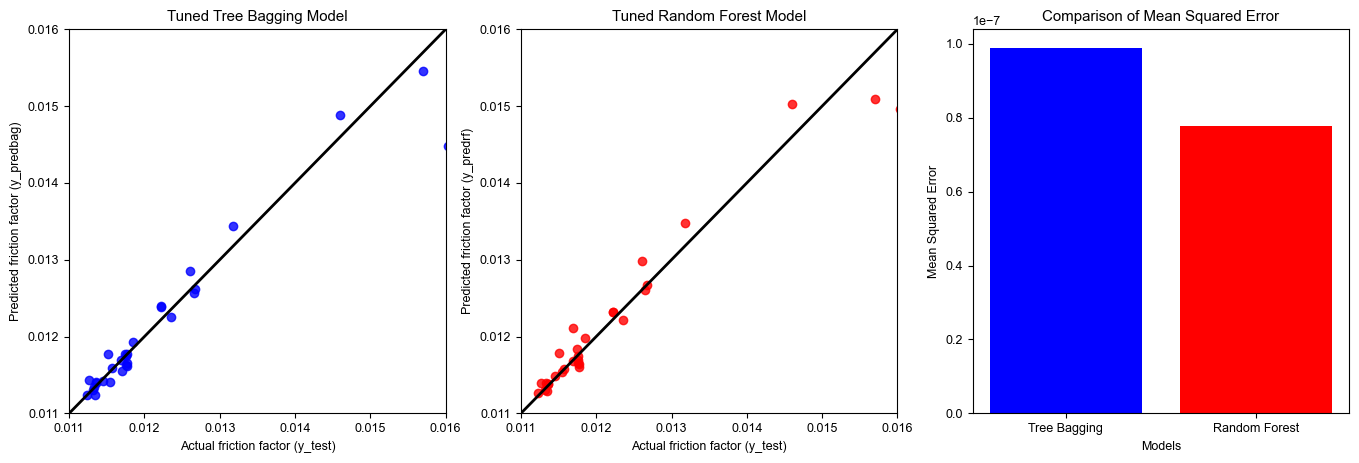

In [45]:
# Visualize the results for final tuned Tree bagging and Random forest model.
plt.subplot(1, 3, 1)  
plt.scatter(y_test, y_predbag, alpha=0.8, color='blue')  
plt.plot([0.011, 0.017], [0.011, 0.017], linestyle='-', color='black', linewidth=2)  
plt.ylim(0.011, 0.016)
plt.xlim(0.011, 0.016)
plt.title('Tuned Tree Bagging Model')
plt.xlabel('Actual friction factor (y_test)')
plt.ylabel('Predicted friction factor (y_predbag)')

plt.subplot(1, 3, 2)  
plt.scatter(y_test, y_predrf, alpha=0.8, color='red')  
plt.plot([0.011, 0.017], [0.011, 0.017], linestyle='-', color='black', linewidth=2)  
plt.ylim(0.011, 0.016)
plt.xlim(0.011, 0.016)
plt.title('Tuned Random Forest Model')
plt.xlabel('Actual friction factor (y_test)')
plt.ylabel('Predicted friction factor (y_predrf)')

plt.subplot(1, 3, 3)
mse_values = [msebag,mserf]
models = ['Tree Bagging','Random Forest']
plt.bar(models, mse_values, color=['blue','red'])  
plt.title('Comparison of Mean Squared Error')  
plt.xlabel('Models') 
plt.ylabel('Mean Squared Error')  
plt.tight_layout()  
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.2, hspace=0.3)
plt.show()

##### Final summary of the results: 

The result proves that the tree decorrelation can improve the mode accuracy based on the histrogram plot of mse for both models, where we can easily conclude that Random forest has superior performance thant tree bagging because it has a smaller mse. It is worthy to point out that the hyperparemeter tuning is signifcant to ensure the fair and accurate comparasion for different 
models. 

### About Me

I am currently a Ph.D. candidate in the Hildebrand Department of Petroleum and Geosystems Engineering. I am part of flow assurance Lab, and am being supervised by Profs. Yingda Lu. My research is focused on $CO_2$ transport in pipelines, including: 
* improved the thermal physical models for $CO_2$ rich mixtures
* developed robust drift flux model for two-phase $CO_2$ pipe flow model
* developed transient $CO_2$ rich mixtures pipe flow model using CFD techniques.
You can contact me at fuqiao.bai@utexas.edu


I hope this was helpful,

*Fuqiao Bai*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
